In [14]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from data.preprocess import load_processed_data
from rl.mdp_formulation import create_mdp_from_dataframes

# Force reload of offline_algorithms module to pick up fixes
import importlib
if 'rl.offline_algorithms' in sys.modules:
    import rl.offline_algorithms
    importlib.reload(rl.offline_algorithms)
from rl.offline_algorithms import train_offline_rl_agent

from rl.policy_evaluation import PolicyEvaluator

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Path('../reports/figs').mkdir(parents=True, exist_ok=True)
Path('../models/saved/rl').mkdir(parents=True, exist_ok=True)

print('✅ Imports complete')

✅ Imports complete


## 1. Load Data & Create MDP

In [15]:
# Load processed data
print('Loading processed data...')
train_df, val_df, test_df = load_processed_data('../data/processed', verbose=True)

# Preprocess data (same as in previous notebooks)
print('\n📊 Preprocessing features...')
from sklearn.preprocessing import LabelEncoder

# Store original for later
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

# Process each dataframe
for df_name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    # Convert date columns to numeric
    date_cols = [col for col in df.columns if 'date' in col.lower() or col in ['issue_d', 'earliest_cr_line', 'sec_app_earliest_cr_line']]
    for col in date_cols:
        if col in df.columns and df[col].dtype == 'object':
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9
            except:
                pass
    
    # Identify categorical columns (excluding 'default')
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if 'default' in cat_cols:
        cat_cols.remove('default')
    
    # Remove high-cardinality ID columns
    id_cols = [col for col in cat_cols if 'id' in col.lower() or col in ['url', 'desc', 'emp_title', 'title']]
    if id_cols:
        df.drop(columns=id_cols, inplace=True)
        cat_cols = [col for col in cat_cols if col not in id_cols]
    
    # Encode categorical features
    if len(cat_cols) > 0:
        for col in cat_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
    
    # Handle remaining non-numeric columns (except 'default')
    remaining_non_numeric = [c for c in df.select_dtypes(exclude=['number']).columns if c != 'default']
    if remaining_non_numeric:
        for col in remaining_non_numeric:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # Fill NaN values
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(-999)

print('✅ Data preprocessed and ready for MDP')

Loading processed data...
✅ Loaded processed data
   Train: 829,355 rows
   Val:   462,426 rows
   Test:  56,318 rows

📊 Preprocessing features...
✅ Loaded processed data
   Train: 829,355 rows
   Val:   462,426 rows
   Test:  56,318 rows

📊 Preprocessing features...
✅ Data preprocessed and ready for MDP
✅ Data preprocessed and ready for MDP


In [16]:
# Create MDP formulation with CRITICAL FIXES
print('\n' + '='*70)
print('CREATING IMPROVED MDP FORMULATION')
print('='*70)

# CRITICAL FIXES TO PREVENT POLICY COLLAPSE:
# 1. Smaller reward scale (0.0005 instead of 0.01) for better gradients
# 2. Add synthetic rejections (20% of defaults) to give CQL rejection examples
# 3. Heavy default penalty (5x multiplier) to encourage risk-averse decisions

mdp, train_dataset, val_dataset, test_dataset = create_mdp_from_dataframes(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    reward_scale=0.0005,  # Smaller scale for better learning
    normalize_states=True,
    add_synthetic_rejections=True,  # CRITICAL: Add rejection examples
    rejection_rate=0.2,  # 20% of defaults marked as "rejected"
    default_penalty_multiplier=5.0  # 5x penalty for defaults
)

# Print action distribution to verify synthetic rejections
print('\n📊 Action Distribution After Synthetic Rejections:')
for name, dataset in [('Train', train_dataset), ('Val', val_dataset), ('Test', test_dataset)]:
    actions = dataset['actions']
    print(f'\n{name} Set:')
    print(f'  Approvals (action=1): {(actions == 1).sum():,} ({(actions == 1).mean()*100:.1f}%)')
    print(f'  Rejections (action=0): {(actions == 0).sum():,} ({(actions == 0).mean()*100:.1f}%)')

print('\n✅ MDP created with anti-collapse improvements!')


CREATING IMPROVED MDP FORMULATION
Inferred 193 valid numeric state features
⚠️  Excluded 32 constant columns

📦 Creating offline RL datasets...
   🔧 Adding synthetic rejections: 20% of defaults
   🔧 Default penalty multiplier: 5.0x
Inferred 193 valid numeric state features
⚠️  Excluded 32 constant columns

📦 Creating offline RL datasets...
   🔧 Adding synthetic rejections: 20% of defaults
   🔧 Default penalty multiplier: 5.0x
   💡 Added 30,613 synthetic rejections (20% of defaults)
      This gives CQL examples of: reject risky loans → avoid losses
   💡 Added 30,613 synthetic rejections (20% of defaults)
      This gives CQL examples of: reject risky loans → avoid losses
   💡 Added 21,484 synthetic rejections (20% of defaults)
      This gives CQL examples of: reject risky loans → avoid losses
   💡 Added 21,484 synthetic rejections (20% of defaults)
      This gives CQL examples of: reject risky loans → avoid losses
✅ Fitted normalization: mean=[2.5119883e-01 4.3385980e+02 1.7584171e+

## 2. Train CQL Agent

In [17]:
# CQL training configuration - AGGRESSIVELY FIXED FOR POLICY COLLAPSE
print('='*70)
print(' IMPROVED CQL CONFIGURATION (ANTI-COLLAPSE)')
print('='*70)

# MOST CRITICAL FIX: Lower cql_alpha from 1.0 to 0.01
# This is the #1 reason for policy collapse - CQL is too conservative!
# Lower alpha = less penalty for out-of-distribution actions = more exploration

CQL_CONFIG = {
    'algorithm': 'CQL',
    'n_epochs': 50,  # More epochs for convergence
    'batch_size': 128,  # Smaller batches = more updates
    'learning_rate': 1e-3,  # Higher learning rate
    'cql_alpha': 0.01,  # CRITICAL: 0.01 instead of 1.0 (100x less conservative!)
    'use_gpu': False,
    'save_path': '../models/saved/rl/cql_agent_improved.pt'
}

print('\n** Configuration:')
for k, v in CQL_CONFIG.items():
    if k == 'cql_alpha':
        print(f'  {k}: {v}  <- 100x LOWER than default (was 1.0)')
    else:
        print(f'  {k}: {v}')

print('\n** Why cql_alpha=0.01 fixes policy collapse:')
print('  - CQL penalizes actions not in the behavioral dataset')
print('  - Alpha=1.0 -> CQL just copies historical policy (100% approvals)')
print('  - Alpha=0.01 -> CQL can explore better decisions (selective rejections)')
print('  - This allows CQL to learn: "reject risky loans = avoid losses"')
print('='*70)

 IMPROVED CQL CONFIGURATION (ANTI-COLLAPSE)

** Configuration:
  algorithm: CQL
  n_epochs: 50
  batch_size: 128
  learning_rate: 0.001
  cql_alpha: 0.01  <- 100x LOWER than default (was 1.0)
  use_gpu: False
  save_path: ../models/saved/rl/cql_agent_improved.pt

** Why cql_alpha=0.01 fixes policy collapse:
  - CQL penalizes actions not in the behavioral dataset
  - Alpha=1.0 -> CQL just copies historical policy (100% approvals)
  - Alpha=0.01 -> CQL can explore better decisions (selective rejections)
  - This allows CQL to learn: "reject risky loans = avoid losses"


### ⚠️ IMPORTANT: Cell Execution Order

**You must run cells in this order:**
1. **Cell 6** (below): Train CQL agent first
2. **Cells 7-12**: Run diagnostic checks (these need the trained `cql_agent`)
3. **Cell 13+**: Behavior Cloning baseline
4. **Cell 14+**: Policy comparisons (needs both `cql_agent` and `bc_actions`)

**Current error:** You ran diagnostic cells before training CQL, or comparison cells before training BC.

In [18]:
# Train CQL agent

print('🔄 Starting CQL training...')
print(f'   Training samples: {len(train_dataset["actions"]):,}')
print(f'   Validation samples: {len(val_dataset["actions"]):,}')
print(f'   Configuration: {CQL_CONFIG["n_epochs"]} epochs, alpha={CQL_CONFIG["cql_alpha"]}')

cql_agent, cql_history = train_offline_rl_agent(
    algorithm='CQL',
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    n_epochs=CQL_CONFIG['n_epochs'],
    batch_size=CQL_CONFIG['batch_size'],
    learning_rate=CQL_CONFIG['learning_rate'],
    use_gpu=CQL_CONFIG['use_gpu'],
    save_path=CQL_CONFIG['save_path'],
    cql_alpha=CQL_CONFIG['cql_alpha']
)

print('\n✅ CQL training complete!')
print('   Now running comprehensive diagnostics to check for policy collapse...')

🔄 Starting CQL training...
   Training samples: 829,355
   Validation samples: 462,426
   Configuration: 50 epochs, alpha=0.01
🤖 Initializing CQL agent
   Device: cpu:0
   Epochs: 50
   Batch size: 128
   Learning rate: 0.001

TRAINING CQL AGENT
2025-12-10 16:46.45 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(193,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-10 16:46.45 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(193,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-10 16:46.45 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-10 16:46.45 [info     ] Action-space has been automatical

Epoch 1/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:48.58 [info     ] DiscreteCQL_20251210164648: epoch=1 step=6479 epoch=1 metrics={'time_sample_batch': 0.0010150543129872826, 'time_algorithm_update': 0.00135914571750015, 'loss': 17.21347602794781, 'td_loss': 17.167929585728128, 'conservative_loss': 4.55464356338768, 'time_step': 0.0024233617648645616, 'td_error': 3718.2508773850795, 'avg_value': 68.36696239294204} step=6479
2025-12-10 16:48.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_6479.d3
2025-12-10 16:48.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_6479.d3


Epoch 2/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:51.06 [info     ] DiscreteCQL_20251210164648: epoch=2 step=12958 epoch=2 metrics={'time_sample_batch': 0.001110977846120018, 'time_algorithm_update': 0.00164716143283529, 'loss': 13.739590154310163, 'td_loss': 13.686625633071944, 'conservative_loss': 5.2964526001162175, 'time_step': 0.002806341340832917, 'td_error': 2135.5034019222735, 'avg_value': 70.19592219502894} step=12958
2025-12-10 16:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_12958.d3
2025-12-10 16:51.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_12958.d3


Epoch 3/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:53.14 [info     ] DiscreteCQL_20251210164648: epoch=3 step=19437 epoch=3 metrics={'time_sample_batch': 0.0011069643256435757, 'time_algorithm_update': 0.001839085187527809, 'loss': 13.304695760933296, 'td_loss': 13.251091900716723, 'conservative_loss': 5.360385963791295, 'time_step': 0.0029968995705010036, 'td_error': 3304.9207427584183, 'avg_value': 69.15990913319948} step=19437
2025-12-10 16:53.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_19437.d3
2025-12-10 16:53.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_19437.d3


Epoch 4/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:55.24 [info     ] DiscreteCQL_20251210164648: epoch=4 step=25916 epoch=4 metrics={'time_sample_batch': 0.0010746766947213285, 'time_algorithm_update': 0.0016893010979210968, 'loss': 13.104933303969016, 'td_loss': 13.050770655920667, 'conservative_loss': 5.41626514608725, 'time_step': 0.0028145650706737934, 'td_error': 2575.619402264244, 'avg_value': 71.53598636302216} step=25916
2025-12-10 16:55.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_25916.d3
2025-12-10 16:55.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_25916.d3


Epoch 5/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:57.32 [info     ] DiscreteCQL_20251210164648: epoch=5 step=32395 epoch=5 metrics={'time_sample_batch': 0.0010996970668179806, 'time_algorithm_update': 0.0016128989277218646, 'loss': 12.891580268177174, 'td_loss': 12.837203921865472, 'conservative_loss': 5.43763443664335, 'time_step': 0.0027603837401985773, 'td_error': 2379.8645796474884, 'avg_value': 65.00592549133565} step=32395
2025-12-10 16:57.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_32395.d3
2025-12-10 16:57.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_32395.d3


Epoch 6/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 16:59.43 [info     ] DiscreteCQL_20251210164648: epoch=6 step=38874 epoch=6 metrics={'time_sample_batch': 0.0010832416954223048, 'time_algorithm_update': 0.0016763870096773365, 'loss': 12.845364971594377, 'td_loss': 12.79009965710258, 'conservative_loss': 5.526531436208185, 'time_step': 0.0028090678646454457, 'td_error': 3107.6326829108684, 'avg_value': 72.9597139402015} step=38874
2025-12-10 16:59.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_38874.d3
2025-12-10 16:59.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_38874.d3


Epoch 7/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:01.56 [info     ] DiscreteCQL_20251210164648: epoch=7 step=45353 epoch=7 metrics={'time_sample_batch': 0.0012519555725530997, 'time_algorithm_update': 0.001993551061447433, 'loss': 12.792430769681452, 'td_loss': 12.737514281202971, 'conservative_loss': 5.4916485587026, 'time_step': 0.0033044340360641185, 'td_error': 3116.541100037684, 'avg_value': 75.22791686528124} step=45353
2025-12-10 17:01.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_45353.d3
2025-12-10 17:01.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_45353.d3


Epoch 8/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:04.06 [info     ] DiscreteCQL_20251210164648: epoch=8 step=51832 epoch=8 metrics={'time_sample_batch': 0.001132066942766357, 'time_algorithm_update': 0.0014799520693032863, 'loss': 12.691311734383959, 'td_loss': 12.636236579941828, 'conservative_loss': 5.50751556594314, 'time_step': 0.002661491952793965, 'td_error': 3448.528232443013, 'avg_value': 73.24272386411364} step=51832
2025-12-10 17:04.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_51832.d3
2025-12-10 17:04.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_51832.d3


Epoch 9/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:06.18 [info     ] DiscreteCQL_20251210164648: epoch=9 step=58311 epoch=9 metrics={'time_sample_batch': 0.0011434215769978986, 'time_algorithm_update': 0.0014800514993080296, 'loss': 12.651156485310711, 'td_loss': 12.595449166471603, 'conservative_loss': 5.570731353108429, 'time_step': 0.0026745603010598883, 'td_error': 2487.736105356562, 'avg_value': 69.13359351499251} step=58311
2025-12-10 17:06.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_58311.d3
2025-12-10 17:06.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_58311.d3


Epoch 10/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:08.27 [info     ] DiscreteCQL_20251210164648: epoch=10 step=64790 epoch=10 metrics={'time_sample_batch': 0.0011337404358550747, 'time_algorithm_update': 0.0014539560540845905, 'loss': 12.519603482660163, 'td_loss': 12.463565301887781, 'conservative_loss': 5.603818582934644, 'time_step': 0.0026362450480884305, 'td_error': 3154.59558030361, 'avg_value': 72.04218262166972} step=64790
2025-12-10 17:08.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_64790.d3
2025-12-10 17:08.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_64790.d3


Epoch 11/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:10.39 [info     ] DiscreteCQL_20251210164648: epoch=11 step=71269 epoch=11 metrics={'time_sample_batch': 0.001188655311006292, 'time_algorithm_update': 0.001577655480478001, 'loss': 12.495136450499476, 'td_loss': 12.439466258849897, 'conservative_loss': 5.567019083007175, 'time_step': 0.0028184754812785517, 'td_error': 2967.9381854187873, 'avg_value': 74.49213356708877} step=71269
2025-12-10 17:10.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_71269.d3
2025-12-10 17:10.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_71269.d3


Epoch 12/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:12.50 [info     ] DiscreteCQL_20251210164648: epoch=12 step=77748 epoch=12 metrics={'time_sample_batch': 0.0011319364546846324, 'time_algorithm_update': 0.0013971601781478577, 'loss': 12.451136680347792, 'td_loss': 12.394775784517957, 'conservative_loss': 5.636089536028339, 'time_step': 0.0025764538708578054, 'td_error': 2411.7443133058896, 'avg_value': 68.41874486587963} step=77748
2025-12-10 17:12.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_77748.d3
2025-12-10 17:12.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_77748.d3


Epoch 13/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:15.03 [info     ] DiscreteCQL_20251210164648: epoch=13 step=84227 epoch=13 metrics={'time_sample_batch': 0.0011369712486331855, 'time_algorithm_update': 0.0014005858398804898, 'loss': 12.347068196646427, 'td_loss': 12.290769837800138, 'conservative_loss': 5.629836044408672, 'time_step': 0.0025849040229115557, 'td_error': 2670.3905853242727, 'avg_value': 73.45496759240768} step=84227
2025-12-10 17:15.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_84227.d3
2025-12-10 17:15.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_84227.d3


Epoch 14/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:17.15 [info     ] DiscreteCQL_20251210164648: epoch=14 step=90706 epoch=14 metrics={'time_sample_batch': 0.0011474477194179482, 'time_algorithm_update': 0.0014028873022626737, 'loss': 12.33995891932923, 'td_loss': 12.283575101608221, 'conservative_loss': 5.638381509091645, 'time_step': 0.0025977337318063612, 'td_error': 2532.765459014139, 'avg_value': 67.39869673370318} step=90706
2025-12-10 17:17.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_90706.d3
2025-12-10 17:17.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_90706.d3


Epoch 15/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:24.49 [info     ] DiscreteCQL_20251210164648: epoch=15 step=97185 epoch=15 metrics={'time_sample_batch': 0.0011489997400989465, 'time_algorithm_update': 0.0014338421221775928, 'loss': 12.185714059966013, 'td_loss': 12.12864397844979, 'conservative_loss': 5.707008445735772, 'time_step': 0.0026314470167788555, 'td_error': 2764.782481984835, 'avg_value': 72.86220508798831} step=97185
2025-12-10 17:24.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_97185.d3
2025-12-10 17:24.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_97185.d3


Epoch 16/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:26.53 [info     ] DiscreteCQL_20251210164648: epoch=16 step=103664 epoch=16 metrics={'time_sample_batch': 0.0010798190879792338, 'time_algorithm_update': 0.0014272494565596052, 'loss': 12.183808674358222, 'td_loss': 12.126268649840911, 'conservative_loss': 5.754002498594179, 'time_step': 0.0025529581780307804, 'td_error': 2960.722649991503, 'avg_value': 76.88224515439359} step=103664
2025-12-10 17:26.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_103664.d3
2025-12-10 17:26.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_103664.d3


Epoch 17/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:28.54 [info     ] DiscreteCQL_20251210164648: epoch=17 step=110143 epoch=17 metrics={'time_sample_batch': 0.0010141677594438787, 'time_algorithm_update': 0.0012865096703229227, 'loss': 12.142971401395648, 'td_loss': 12.085602594573734, 'conservative_loss': 5.736879924203276, 'time_step': 0.0023449123006927543, 'td_error': 2628.7544318688356, 'avg_value': 73.8402521027282} step=110143
2025-12-10 17:28.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_110143.d3
2025-12-10 17:28.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_110143.d3


Epoch 18/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:31.04 [info     ] DiscreteCQL_20251210164648: epoch=18 step=116622 epoch=18 metrics={'time_sample_batch': 0.001075414324049634, 'time_algorithm_update': 0.001341598419187098, 'loss': 12.072755207414152, 'td_loss': 12.01524164875747, 'conservative_loss': 5.751355483385125, 'time_step': 0.0024628172982049993, 'td_error': 3031.977491859214, 'avg_value': 76.9306803402284} step=116622
2025-12-10 17:31.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_116622.d3
2025-12-10 17:31.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_116622.d3


Epoch 19/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:33.16 [info     ] DiscreteCQL_20251210164648: epoch=19 step=123101 epoch=19 metrics={'time_sample_batch': 0.001134715159010383, 'time_algorithm_update': 0.0014181381428125814, 'loss': 12.000900526660555, 'td_loss': 11.943081680722655, 'conservative_loss': 5.781884823542426, 'time_step': 0.0026015596894648253, 'td_error': 2660.0450198699505, 'avg_value': 74.4775717631693} step=123101
2025-12-10 17:33.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_123101.d3
2025-12-10 17:33.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_123101.d3


Epoch 20/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 17:35.33 [info     ] DiscreteCQL_20251210164648: epoch=20 step=129580 epoch=20 metrics={'time_sample_batch': 0.0011416043851051384, 'time_algorithm_update': 0.001457387787597675, 'loss': 11.900741024432422, 'td_loss': 11.842936587142326, 'conservative_loss': 5.780443259421865, 'time_step': 0.0026478437678941627, 'td_error': 3002.54088383665, 'avg_value': 76.80535136657296} step=129580
2025-12-10 17:35.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_129580.d3
2025-12-10 17:35.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_129580.d3


Epoch 21/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:08.07 [info     ] DiscreteCQL_20251210164648: epoch=21 step=136059 epoch=21 metrics={'time_sample_batch': 0.001173968262870401, 'time_algorithm_update': 0.0016802224981911776, 'loss': 11.876256521404258, 'td_loss': 11.818643224149193, 'conservative_loss': 5.761329135623937, 'time_step': 0.0029047632460278447, 'td_error': 2582.804639862541, 'avg_value': 70.4026865850178} step=136059
2025-12-10 18:08.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_136059.d3
2025-12-10 18:08.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_136059.d3


Epoch 22/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:13.03 [info     ] DiscreteCQL_20251210164648: epoch=22 step=142538 epoch=22 metrics={'time_sample_batch': 0.001487970204978174, 'time_algorithm_update': 0.02781677982067138, 'loss': 11.923606419033392, 'td_loss': 11.865652986580363, 'conservative_loss': 5.795343161144454, 'time_step': 0.029362936228913904, 'td_error': 2530.030378812321, 'avg_value': 73.24327208761336} step=142538
2025-12-10 18:13.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_142538.d3
2025-12-10 18:13.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_142538.d3


Epoch 23/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:15.07 [info     ] DiscreteCQL_20251210164648: epoch=23 step=149017 epoch=23 metrics={'time_sample_batch': 0.001113765124535741, 'time_algorithm_update': 0.0016812728426121215, 'loss': 11.968006175652498, 'td_loss': 11.90962725790365, 'conservative_loss': 5.837892017608845, 'time_step': 0.0028436063229807696, 'td_error': 2951.4080701630182, 'avg_value': 75.77843591983137} step=149017
2025-12-10 18:15.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_149017.d3
2025-12-10 18:15.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_149017.d3


Epoch 24/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:17.10 [info     ] DiscreteCQL_20251210164648: epoch=24 step=155496 epoch=24 metrics={'time_sample_batch': 0.0011827479102100409, 'time_algorithm_update': 0.0015955117036207422, 'loss': 11.746173993675296, 'td_loss': 11.688205397539363, 'conservative_loss': 5.796860152472867, 'time_step': 0.002824882313616023, 'td_error': 2689.193292544872, 'avg_value': 73.73890459149644} step=155496
2025-12-10 18:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_155496.d3
2025-12-10 18:17.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_155496.d3


Epoch 25/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:19.11 [info     ] DiscreteCQL_20251210164648: epoch=25 step=161975 epoch=25 metrics={'time_sample_batch': 0.0010075200798151246, 'time_algorithm_update': 0.0013780468020620933, 'loss': 11.779228196833712, 'td_loss': 11.721007186351946, 'conservative_loss': 5.822101507810259, 'time_step': 0.0024278818926227594, 'td_error': 2474.423876056681, 'avg_value': 71.0936212082964} step=161975
2025-12-10 18:19.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_161975.d3
2025-12-10 18:19.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_161975.d3


Epoch 26/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:21.12 [info     ] DiscreteCQL_20251210164648: epoch=26 step=168454 epoch=26 metrics={'time_sample_batch': 0.0010134796979232672, 'time_algorithm_update': 0.0014120675399175008, 'loss': 11.73772058198621, 'td_loss': 11.679419542144599, 'conservative_loss': 5.830103877122838, 'time_step': 0.002468487752368925, 'td_error': 2686.896306882406, 'avg_value': 71.12469379874346} step=168454
2025-12-10 18:21.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_168454.d3
2025-12-10 18:21.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_168454.d3


Epoch 27/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:23.17 [info     ] DiscreteCQL_20251210164648: epoch=27 step=174933 epoch=27 metrics={'time_sample_batch': 0.0010138512172896215, 'time_algorithm_update': 0.0014042770776102472, 'loss': 11.68030093328547, 'td_loss': 11.621953386862275, 'conservative_loss': 5.8347541279107595, 'time_step': 0.00246149574759051, 'td_error': 2887.1799564845933, 'avg_value': 76.5008470699603} step=174933
2025-12-10 18:23.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_174933.d3
2025-12-10 18:23.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_174933.d3


Epoch 28/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:25.28 [info     ] DiscreteCQL_20251210164648: epoch=28 step=181412 epoch=28 metrics={'time_sample_batch': 0.0012056680718475073, 'time_algorithm_update': 0.0018760844464838589, 'loss': 11.729101710599926, 'td_loss': 11.6708595422264, 'conservative_loss': 5.824216533965729, 'time_step': 0.003135806783001113, 'td_error': 3079.5709230973807, 'avg_value': 76.08634052069219} step=181412
2025-12-10 18:25.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_181412.d3
2025-12-10 18:25.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_181412.d3


Epoch 29/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:27.40 [info     ] DiscreteCQL_20251210164648: epoch=29 step=187891 epoch=29 metrics={'time_sample_batch': 0.0011228860427354805, 'time_algorithm_update': 0.0015953736718117887, 'loss': 11.618094387678548, 'td_loss': 11.559247495050249, 'conservative_loss': 5.884689312876144, 'time_step': 0.002767206434299041, 'td_error': 2742.080022578366, 'avg_value': 71.53719541451744} step=187891
2025-12-10 18:27.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_187891.d3
2025-12-10 18:27.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_187891.d3


Epoch 30/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:29.56 [info     ] DiscreteCQL_20251210164648: epoch=30 step=194370 epoch=30 metrics={'time_sample_batch': 0.0011700763619963558, 'time_algorithm_update': 0.0016998428127467217, 'loss': 11.707834800759075, 'td_loss': 11.648855625212349, 'conservative_loss': 5.897917071487602, 'time_step': 0.0029207157636060447, 'td_error': 2486.0761259760843, 'avg_value': 71.18953304478791} step=194370
2025-12-10 18:29.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_194370.d3
2025-12-10 18:29.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_194370.d3


Epoch 31/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:32.08 [info     ] DiscreteCQL_20251210164648: epoch=31 step=200849 epoch=31 metrics={'time_sample_batch': 0.0012049424756840987, 'time_algorithm_update': 0.001757450062545256, 'loss': 11.621591629943724, 'td_loss': 11.562988409677356, 'conservative_loss': 5.8603218664153705, 'time_step': 0.0030145781296678376, 'td_error': 2696.7977390822975, 'avg_value': 73.00568572795491} step=200849
2025-12-10 18:32.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_200849.d3
2025-12-10 18:32.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_200849.d3


Epoch 32/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:34.24 [info     ] DiscreteCQL_20251210164648: epoch=32 step=207328 epoch=32 metrics={'time_sample_batch': 0.0013233505478058357, 'time_algorithm_update': 0.0019694124222684926, 'loss': 11.584776082880097, 'td_loss': 11.525609608343453, 'conservative_loss': 5.916647723527359, 'time_step': 0.0033489806653173053, 'td_error': 2515.47259362392, 'avg_value': 73.13706902789082} step=207328
2025-12-10 18:34.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_207328.d3
2025-12-10 18:34.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_207328.d3


Epoch 33/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:36.44 [info     ] DiscreteCQL_20251210164648: epoch=33 step=213807 epoch=33 metrics={'time_sample_batch': 0.0012589926557015408, 'time_algorithm_update': 0.0018851179310450823, 'loss': 11.620429524099924, 'td_loss': 11.56161153728643, 'conservative_loss': 5.881798574228606, 'time_step': 0.0031969608357519733, 'td_error': 2793.6351336577986, 'avg_value': 72.32501717931544} step=213807
2025-12-10 18:36.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_213807.d3
2025-12-10 18:36.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_213807.d3


Epoch 34/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:39.01 [info     ] DiscreteCQL_20251210164648: epoch=34 step=220286 epoch=34 metrics={'time_sample_batch': 0.001211219850302589, 'time_algorithm_update': 0.0017717771828956563, 'loss': 11.367412820598707, 'td_loss': 11.308460930722568, 'conservative_loss': 5.895189190448149, 'time_step': 0.0030356672263141767, 'td_error': 2855.372735377055, 'avg_value': 72.94919614930849} step=220286
2025-12-10 18:39.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_220286.d3
2025-12-10 18:39.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_220286.d3


Epoch 35/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:41.10 [info     ] DiscreteCQL_20251210164648: epoch=35 step=226765 epoch=35 metrics={'time_sample_batch': 0.0011930888514953698, 'time_algorithm_update': 0.0015531225435563417, 'loss': 11.455986742896787, 'td_loss': 11.396709495073559, 'conservative_loss': 5.927724350711265, 'time_step': 0.0027986218263602843, 'td_error': 2756.205758102315, 'avg_value': 72.68112482654328} step=226765
2025-12-10 18:41.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_226765.d3
2025-12-10 18:41.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_226765.d3


Epoch 36/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:43.20 [info     ] DiscreteCQL_20251210164648: epoch=36 step=233244 epoch=36 metrics={'time_sample_batch': 0.0012271915399875515, 'time_algorithm_update': 0.001651047997902271, 'loss': 11.327908733382714, 'td_loss': 11.26871887636435, 'conservative_loss': 5.918985878010005, 'time_step': 0.002934751512092064, 'td_error': 2788.493508420147, 'avg_value': 73.92736305185684} step=233244
2025-12-10 18:43.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_233244.d3
2025-12-10 18:43.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_233244.d3


Epoch 37/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:45.30 [info     ] DiscreteCQL_20251210164648: epoch=37 step=239723 epoch=37 metrics={'time_sample_batch': 0.0011487972002225187, 'time_algorithm_update': 0.0014621361775022173, 'loss': 11.389006709349635, 'td_loss': 11.330199450213042, 'conservative_loss': 5.880726319879896, 'time_step': 0.002661238557156414, 'td_error': 3483.168229850673, 'avg_value': 77.95203629513202} step=239723
2025-12-10 18:45.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_239723.d3
2025-12-10 18:45.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_239723.d3


Epoch 38/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:47.41 [info     ] DiscreteCQL_20251210164648: epoch=38 step=246202 epoch=38 metrics={'time_sample_batch': 0.0011730558398624026, 'time_algorithm_update': 0.001491611212524188, 'loss': 11.385892540497036, 'td_loss': 11.327050318981435, 'conservative_loss': 5.884222434615441, 'time_step': 0.0027158252249751716, 'td_error': 2425.047676589563, 'avg_value': 74.22224646034368} step=246202
2025-12-10 18:47.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_246202.d3
2025-12-10 18:47.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_246202.d3


Epoch 39/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:49.51 [info     ] DiscreteCQL_20251210164648: epoch=39 step=252681 epoch=39 metrics={'time_sample_batch': 0.0011752584242198843, 'time_algorithm_update': 0.0015012052880151899, 'loss': 11.280587096128922, 'td_loss': 11.221722227792199, 'conservative_loss': 5.886486208977974, 'time_step': 0.0027265016229308338, 'td_error': 2972.2141912160696, 'avg_value': 73.68901473557536} step=252681
2025-12-10 18:49.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_252681.d3
2025-12-10 18:49.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_252681.d3


Epoch 40/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:52.04 [info     ] DiscreteCQL_20251210164648: epoch=40 step=259160 epoch=40 metrics={'time_sample_batch': 0.0013034737097258405, 'time_algorithm_update': 0.0017578399444476453, 'loss': 11.350862365167144, 'td_loss': 11.291877695321485, 'conservative_loss': 5.898467004768347, 'time_step': 0.003118229383376484, 'td_error': 3297.5008631954706, 'avg_value': 76.9963184343259} step=259160
2025-12-10 18:52.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_259160.d3
2025-12-10 18:52.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_259160.d3


Epoch 41/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:54.16 [info     ] DiscreteCQL_20251210164648: epoch=41 step=265639 epoch=41 metrics={'time_sample_batch': 0.0011161046367420939, 'time_algorithm_update': 0.001402422903054731, 'loss': 11.320046308563528, 'td_loss': 11.260894436677273, 'conservative_loss': 5.915187188478362, 'time_step': 0.0025658875745210147, 'td_error': 2855.3552249133345, 'avg_value': 73.68856236807086} step=265639
2025-12-10 18:54.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_265639.d3
2025-12-10 18:54.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_265639.d3


Epoch 42/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:56.31 [info     ] DiscreteCQL_20251210164648: epoch=42 step=272118 epoch=42 metrics={'time_sample_batch': 0.0011353947568370302, 'time_algorithm_update': 0.0014228511691958213, 'loss': 11.24772045648766, 'td_loss': 11.188372155769608, 'conservative_loss': 5.934830118852148, 'time_step': 0.0026081136796812635, 'td_error': 2646.737654999467, 'avg_value': 72.3548098451087} step=272118
2025-12-10 18:56.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_272118.d3
2025-12-10 18:56.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_272118.d3


Epoch 43/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 18:58.45 [info     ] DiscreteCQL_20251210164648: epoch=43 step=278597 epoch=43 metrics={'time_sample_batch': 0.0011247103367714368, 'time_algorithm_update': 0.001373278430480062, 'loss': 11.211120455514171, 'td_loss': 11.152281221038564, 'conservative_loss': 5.8839227445406355, 'time_step': 0.0025447157912645135, 'td_error': 2909.306326291008, 'avg_value': 75.47902505829873} step=278597
2025-12-10 18:58.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_278597.d3
2025-12-10 18:58.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_278597.d3


Epoch 44/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:01.12 [info     ] DiscreteCQL_20251210164648: epoch=44 step=285076 epoch=44 metrics={'time_sample_batch': 0.0014532280660076705, 'time_algorithm_update': 0.0018584845996708905, 'loss': 11.22815261493956, 'td_loss': 11.169096293484728, 'conservative_loss': 5.905633070417752, 'time_step': 0.0033753659736596798, 'td_error': 2383.001548013396, 'avg_value': 68.55202457273982} step=285076
2025-12-10 19:01.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_285076.d3
2025-12-10 19:01.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_285076.d3


Epoch 45/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:03.31 [info     ] DiscreteCQL_20251210164648: epoch=45 step=291555 epoch=45 metrics={'time_sample_batch': 0.0011911652378506785, 'time_algorithm_update': 0.001524076397026334, 'loss': 11.281615228725816, 'td_loss': 11.222454506538774, 'conservative_loss': 5.916072187553973, 'time_step': 0.002765794874139177, 'td_error': 3046.9379263487613, 'avg_value': 74.39546085182624} step=291555
2025-12-10 19:03.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_291555.d3
2025-12-10 19:03.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_291555.d3


Epoch 46/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:05.53 [info     ] DiscreteCQL_20251210164648: epoch=46 step=298034 epoch=46 metrics={'time_sample_batch': 0.0012241160175943471, 'time_algorithm_update': 0.0016359079213472847, 'loss': 11.091597068823125, 'td_loss': 11.032227754795288, 'conservative_loss': 5.936932091875602, 'time_step': 0.0029136610538949568, 'td_error': 2921.6395765952248, 'avg_value': 71.13718262197466} step=298034
2025-12-10 19:05.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_298034.d3
2025-12-10 19:05.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_298034.d3


Epoch 47/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:08.13 [info     ] DiscreteCQL_20251210164648: epoch=47 step=304513 epoch=47 metrics={'time_sample_batch': 0.0012346971805935786, 'time_algorithm_update': 0.0015869542098483254, 'loss': 11.200549036213822, 'td_loss': 11.141270807356467, 'conservative_loss': 5.927822496019261, 'time_step': 0.0028751810532805545, 'td_error': 3081.4244474258226, 'avg_value': 72.39944166423726} step=304513
2025-12-10 19:08.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_304513.d3
2025-12-10 19:08.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_304513.d3


Epoch 48/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:10.41 [info     ] DiscreteCQL_20251210164648: epoch=48 step=310992 epoch=48 metrics={'time_sample_batch': 0.0012546955646786319, 'time_algorithm_update': 0.0018222371007321995, 'loss': 11.080462735971379, 'td_loss': 11.02104936976881, 'conservative_loss': 5.941336118341467, 'time_step': 0.0031298151868492537, 'td_error': 3074.7057006523087, 'avg_value': 73.34600376673065} step=310992
2025-12-10 19:10.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_310992.d3
2025-12-10 19:10.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_310992.d3


Epoch 49/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:13.08 [info     ] DiscreteCQL_20251210164648: epoch=49 step=317471 epoch=49 metrics={'time_sample_batch': 0.0012619830259737327, 'time_algorithm_update': 0.001940719874152837, 'loss': 11.064996943464248, 'td_loss': 11.005428976253846, 'conservative_loss': 5.956796351747208, 'time_step': 0.003257668888629596, 'td_error': 2938.0381821058522, 'avg_value': 73.49856731302482} step=317471
2025-12-10 19:13.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_317471.d3
2025-12-10 19:13.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_317471.d3


Epoch 50/50:   0%|          | 0/6479 [00:00<?, ?it/s]

2025-12-10 19:15.20 [info     ] DiscreteCQL_20251210164648: epoch=50 step=323950 epoch=50 metrics={'time_sample_batch': 0.0011526642987933823, 'time_algorithm_update': 0.0016004338568422342, 'loss': 11.059012396907086, 'td_loss': 10.999694957678324, 'conservative_loss': 5.9317436514675, 'time_step': 0.0028011215967719137, 'td_error': 4024.5368384958474, 'avg_value': 64.99923774195665} step=323950
2025-12-10 19:15.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_323950.d3
2025-12-10 19:15.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251210164648/model_323950.d3

✅ Training complete!
✅ Model saved: ../models/saved/rl/cql_agent_improved_model.d3
✅ Config saved: ../models/saved/rl/cql_agent_improved_config.json

✅ CQL training complete!
   Now running comprehensive diagnostics to check for policy collapse...

✅ Training complete!
✅ Model saved: ../models/saved/rl/cql_agent_improved_model.d3
✅ Config saved: ../models/saved/r

## 2.1 CRITICAL SANITY CHECKS - Dataset Verification

In [19]:
# SANITY CHECK 1: Verify action encoding and distribution
print('='*70)
print('SANITY CHECK 1: ACTION ENCODING & DISTRIBUTION')
print('='*70)

def action_stats(dataset, name='Dataset'):
    """Check action domain and counts"""
    actions = np.asarray(dataset['actions'])
    unique, counts = np.unique(actions, return_counts=True)
    print(f"\n{name} actions unique values: {unique}")
    for u, c in zip(unique, counts):
        print(f"  action={u}: {c:,} ({c/len(actions)*100:.2f}%)")
    return unique, counts

print('\n📊 Checking all datasets for action encoding...')
train_unique, train_counts = action_stats(train_dataset, 'Train')
val_unique, val_counts = action_stats(val_dataset, 'Val')
test_unique, test_counts = action_stats(test_dataset, 'Test')

# CRITICAL CHECK: Are there ANY rejections (action=0)?
train_rejections = train_counts[train_unique == 0].sum() if 0 in train_unique else 0
val_rejections = val_counts[val_unique == 0].sum() if 0 in val_unique else 0
test_rejections = test_counts[test_unique == 0].sum() if 0 in test_unique else 0

print('\n' + '='*70)
print('🔍 REJECTION VERIFICATION:')
print('='*70)
print(f"Train rejections: {train_rejections:,}")
print(f"Val rejections:   {val_rejections:,}")
print(f"Test rejections:  {test_rejections:,}")

if train_rejections == 0:
    print('\n❌ CRITICAL ERROR: NO REJECTIONS IN TRAINING DATA!')
    print('   This explains policy collapse - CQL has no rejection examples.')
    print('   The synthetic rejection code may have failed.')
elif train_rejections < 0.05 * len(train_dataset['actions']):
    print(f'\n⚠️  WARNING: Only {train_rejections/len(train_dataset["actions"])*100:.1f}% rejections')
    print('   CQL needs ~10-30% rejection examples to learn properly.')
else:
    print(f'\n✅ GOOD: {train_rejections/len(train_dataset["actions"])*100:.1f}% rejections present')

print('='*70)

SANITY CHECK 1: ACTION ENCODING & DISTRIBUTION

📊 Checking all datasets for action encoding...

Train actions unique values: [0 1]
  action=0: 30,613 (3.69%)
  action=1: 798,742 (96.31%)

Val actions unique values: [0 1]
  action=0: 21,484 (4.65%)
  action=1: 440,942 (95.35%)

Test actions unique values: [1]
  action=1: 56,318 (100.00%)

🔍 REJECTION VERIFICATION:
Train rejections: 30,613
Val rejections:   21,484
Test rejections:  0

⚠️  WARNING: Only 3.7% rejections
   CQL needs ~10-30% rejection examples to learn properly.


In [20]:
# SANITY CHECK 2: Verify synthetic rejections were actually created
print('='*70)
print('SANITY CHECK 2: SYNTHETIC REJECTION DETAILS')
print('='*70)

# Check if datasets have 'outcomes' (0=paid, 1=default)
if 'outcomes' in train_dataset:
    train_outcomes = np.asarray(train_dataset['outcomes'])
    train_actions = np.asarray(train_dataset['actions'])
    
    # Count defaults and rejections
    n_defaults = (train_outcomes == 1).sum()
    n_rejections = (train_actions == 0).sum()
    
    # Check correlation: synthetic rejections should be high-risk (defaults)
    defaults_rejected = ((train_outcomes == 1) & (train_actions == 0)).sum()
    defaults_approved = ((train_outcomes == 1) & (train_actions == 1)).sum()
    paid_rejected = ((train_outcomes == 0) & (train_actions == 0)).sum()
    paid_approved = ((train_outcomes == 0) & (train_actions == 1)).sum()
    
    print(f'\n📊 Training set breakdown:')
    print(f'  Total samples: {len(train_actions):,}')
    print(f'  Defaults: {n_defaults:,} ({n_defaults/len(train_actions)*100:.1f}%)')
    print(f'  Rejections: {n_rejections:,} ({n_rejections/len(train_actions)*100:.1f}%)')
    
    print(f'\n📊 Action × Outcome matrix:')
    print(f'  Paid + Approved:   {paid_approved:,} ({paid_approved/len(train_actions)*100:.1f}%)')
    print(f'  Paid + Rejected:   {paid_rejected:,} ({paid_rejected/len(train_actions)*100:.1f}%)')
    print(f'  Default + Approved: {defaults_approved:,} ({defaults_approved/len(train_actions)*100:.1f}%)')
    print(f'  Default + Rejected: {defaults_rejected:,} ({defaults_rejected/len(train_actions)*100:.1f}%)')
    
    print(f'\n🎯 Synthetic rejection effectiveness:')
    if n_rejections > 0:
        rejection_default_rate = defaults_rejected / n_rejections if n_rejections > 0 else 0
        print(f'  {rejection_default_rate*100:.1f}% of rejections are high-risk (defaults)')
        if rejection_default_rate > 0.8:
            print('  ✅ GOOD: Rejections target high-risk loans')
        else:
            print('  ⚠️  WARNING: Rejections not well-targeted to risky loans')
    else:
        print('  ❌ NO REJECTIONS to analyze')
        
else:
    print('⚠️  No "outcomes" field found in dataset - cannot verify synthetic rejections')

print('='*70)

SANITY CHECK 2: SYNTHETIC REJECTION DETAILS

📊 Training set breakdown:
  Total samples: 829,355
  Defaults: 153,065 (18.5%)
  Rejections: 30,613 (3.7%)

📊 Action × Outcome matrix:
  Paid + Approved:   676,290 (81.5%)
  Paid + Rejected:   0 (0.0%)
  Default + Approved: 122,452 (14.8%)
  Default + Rejected: 30,613 (3.7%)

🎯 Synthetic rejection effectiveness:
  100.0% of rejections are high-risk (defaults)
  ✅ GOOD: Rejections target high-risk loans


In [21]:
# SANITY CHECK 3: Compute policy divergence (CQL vs historical)
print('='*70)
print('SANITY CHECK 3: POLICY DIVERGENCE')
print('='*70)

def compute_policy_divergence(agent, dataset, name='Dataset', batch_size=4096):
    """Compute % of states where policy action != historical action"""
    states = dataset['observations'] if 'observations' in dataset else dataset['states']
    hist_actions = np.asarray(dataset['actions'])
    
    # Batch prediction for speed
    print(f'\n🔄 Predicting {name} actions for {len(states):,} states...')
    pred_actions = []
    for i in range(0, len(states), batch_size):
        batch_states = states[i:i+batch_size]
        batch_preds = agent.predict(batch_states)
        pred_actions.append(batch_preds)
    pred_actions = np.concatenate(pred_actions)
    
    # Compute divergence
    diff_mask = (pred_actions != hist_actions)
    n_different = diff_mask.sum()
    pct_different = diff_mask.mean() * 100
    
    print(f'\n📊 {name} Policy Divergence:')
    print(f'  Different decisions: {n_different:,} / {len(states):,}')
    print(f'  Divergence: {pct_different:.2f}%')
    
    # Detailed breakdown
    hist_approve = (hist_actions == 1).sum()
    hist_reject = (hist_actions == 0).sum()
    pred_approve = (pred_actions == 1).sum()
    pred_reject = (pred_actions == 0).sum()
    
    # Agreement matrix
    both_approve = ((hist_actions == 1) & (pred_actions == 1)).sum()
    both_reject = ((hist_actions == 0) & (pred_actions == 0)).sum()
    hist_approve_cql_reject = ((hist_actions == 1) & (pred_actions == 0)).sum()
    hist_reject_cql_approve = ((hist_actions == 0) & (pred_actions == 1)).sum()
    
    print(f'\n  Agreement matrix:')
    print(f'    Both approve:  {both_approve:,} ({both_approve/len(states)*100:.1f}%)')
    print(f'    Both reject:   {both_reject:,} ({both_reject/len(states)*100:.1f}%)')
    print(f'    Hist→Approve, CQL→Reject: {hist_approve_cql_reject:,} ({hist_approve_cql_reject/len(states)*100:.1f}%)')
    print(f'    Hist→Reject, CQL→Approve: {hist_reject_cql_approve:,} ({hist_reject_cql_approve/len(states)*100:.1f}%)')
    
    return pct_different, pred_actions

# Compute divergence on train and test
train_divergence, train_cql_actions = compute_policy_divergence(cql_agent, train_dataset, 'Train')
test_divergence, test_cql_actions = compute_policy_divergence(cql_agent, test_dataset, 'Test')

print('\n' + '='*70)
print('🎯 DIVERGENCE INTERPRETATION:')
print('='*70)
if train_divergence < 1:
    print('❌ CRITICAL: POLICY COLLAPSE CONFIRMED')
    print('   CQL is copying the behavioral policy (< 1% divergence)')
    print('   Recommendation: Lower cql_alpha to 0.001 or try IQL/BCQ')
elif train_divergence < 5:
    print('⚠️  WARNING: Low divergence - weak learning')
    print('   CQL shows some deviation but not strong')
    print('   Recommendation: Lower cql_alpha to 0.001-0.005')
elif train_divergence < 10:
    print('✅ MODERATE: CQL is learning different decisions')
    print('   Need to verify if these improve value (see OPE below)')
else:
    print('✅ STRONG: CQL significantly diverged from behavioral policy')
    print('   Check if this improves value or is just random exploration')

print('='*70)

SANITY CHECK 3: POLICY DIVERGENCE

🔄 Predicting Train actions for 829,355 states...

📊 Train Policy Divergence:
  Different decisions: 108,518 / 829,355
  Divergence: 13.08%

  Agreement matrix:
    Both approve:  702,531 (84.7%)
    Both reject:   18,306 (2.2%)
    Hist→Approve, CQL→Reject: 96,211 (11.6%)
    Hist→Reject, CQL→Approve: 12,307 (1.5%)

🔄 Predicting Test actions for 56,318 states...

📊 Test Policy Divergence:
  Different decisions: 5,445 / 56,318
  Divergence: 9.67%

  Agreement matrix:
    Both approve:  50,873 (90.3%)
    Both reject:   0 (0.0%)
    Hist→Approve, CQL→Reject: 5,445 (9.7%)
    Hist→Reject, CQL→Approve: 0 (0.0%)

🎯 DIVERGENCE INTERPRETATION:
✅ STRONG: CQL significantly diverged from behavioral policy
   Check if this improves value or is just random exploration


In [22]:
# SANITY CHECK 4: Offline Policy Evaluation (IPS)
print('='*70)
print('SANITY CHECK 4: OFFLINE POLICY EVALUATION (IPS)')
print('='*70)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score

# Step 1: Fit behavior policy model (to estimate p_b(a|s))
print('\n🔄 Step 1: Training behavior policy model...')
print('   (This models the historical action probabilities)')

X = train_dataset['observations'] if 'observations' in train_dataset else train_dataset['states']
y = train_dataset['actions']

# Use 80/20 split for behavior model training/validation
X_train_bp, X_val_bp, y_train_bp, y_val_bp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y)) > 1 else None
)

# Train classifier to predict historical actions
behavior_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=15,
    min_samples_split=100,
    n_jobs=-1,
    random_state=42
)
behavior_model.fit(X_train_bp, y_train_bp)

# Evaluate behavior model quality
y_pred_bp = behavior_model.predict(X_val_bp)
y_proba_bp = behavior_model.predict_proba(X_val_bp)
bp_accuracy = accuracy_score(y_val_bp, y_pred_bp)
bp_logloss = log_loss(y_val_bp, y_proba_bp)

print(f'   Behavior model accuracy: {bp_accuracy:.3f}')
print(f'   Behavior model logloss: {bp_logloss:.4f}')
if bp_accuracy < 0.6:
    print('   ⚠️  WARNING: Poor behavior model quality - IPS may be unreliable')
else:
    print('   ✅ Behavior model looks reasonable')

# Step 2: Compute IPS estimates
print('\n🔄 Step 2: Computing Importance Sampling estimates...')

def compute_ips_value(states, actions_hist, actions_new, rewards, behavior_model, 
                      self_normalized=True, clip_ratio=None):
    """
    Compute IPS value estimate for a new policy
    
    Args:
        states: State observations
        actions_hist: Historical actions from data
        actions_new: Actions from new policy
        rewards: Observed rewards
        behavior_model: Fitted classifier for p_b(a|s)
        self_normalized: Use self-normalized IPS (more stable)
        clip_ratio: Clip importance ratios (e.g., 10.0 or 100.0)
    """
    # Get behavior probabilities
    probs_all = behavior_model.predict_proba(states)
    
    # Get p_b(a_hist|s) - probability of historical action
    p_b_hist = np.array([probs_all[i, int(a)] for i, a in enumerate(actions_hist)])
    
    # Get p_b(a_new|s) - probability of new policy action under behavior
    p_b_new = np.array([probs_all[i, int(a)] for i, a in enumerate(actions_new)])
    
    # For deterministic new policy: pi(a_new|s) = 1
    # Importance ratio: pi(a_new|s) / p_b(a_new|s) = 1 / p_b(a_new|s)
    # But we need to match actions: ratio = 1 if a_new == a_hist, else 0
    # Actually: ratio = pi(a_hist|s) / p_b(a_hist|s)
    # For deterministic policy: pi(a_hist|s) = 1{a_hist == a_new}
    
    ratios = np.where(actions_hist == actions_new, 1.0 / (p_b_hist + 1e-8), 0.0)
    
    # Clip ratios if specified
    if clip_ratio is not None:
        ratios = np.clip(ratios, 0, clip_ratio)
    
    # Compute IPS
    if self_normalized:
        value_est = np.sum(ratios * rewards) / (np.sum(ratios) + 1e-8)
    else:
        value_est = np.mean(ratios * rewards)
    
    # Compute effective sample size
    ess = (np.sum(ratios)**2) / (np.sum(ratios**2) + 1e-8)
    
    return value_est, ratios, ess

# Get rewards from dataset
train_rewards = np.asarray(train_dataset['rewards'])
test_rewards = np.asarray(test_dataset['rewards'])
test_states = test_dataset['observations'] if 'observations' in test_dataset else test_dataset['states']
test_actions_hist = np.asarray(test_dataset['actions'])

# Compute IPS for behavioral policy (should match empirical mean)
behavioral_value, _, _ = compute_ips_value(
    test_states, test_actions_hist, test_actions_hist, 
    test_rewards, behavior_model, self_normalized=True
)

# Compute IPS for CQL policy
cql_value, cql_ratios, cql_ess = compute_ips_value(
    test_states, test_actions_hist, test_cql_actions, 
    test_rewards, behavior_model, self_normalized=True, clip_ratio=100.0
)

print('\n📊 IPS Value Estimates (self-normalized, clipped at 100):')
print(f'  Behavioral policy value: {behavioral_value:.6f}')
print(f'  CQL policy value:        {cql_value:.6f}')
print(f'  Improvement:             {(cql_value - behavioral_value):.6f} ({(cql_value/behavioral_value - 1)*100:+.2f}%)')
print(f'\n  CQL Effective Sample Size: {cql_ess:.0f} / {len(test_states):,} ({cql_ess/len(test_states)*100:.1f}%)')

# Statistics on importance ratios
print(f'\n  CQL Importance ratio stats:')
print(f'    Mean:   {cql_ratios.mean():.3f}')
print(f'    Median: {np.median(cql_ratios):.3f}')
print(f'    Max:    {cql_ratios.max():.3f}')
print(f'    % zeros: {(cql_ratios == 0).mean()*100:.1f}%')

if cql_ess / len(test_states) < 0.05:
    print('\n  ⚠️  WARNING: Very low ESS - IPS estimate may be unreliable')
    print('      High variance due to distribution shift')

print('='*70)

SANITY CHECK 4: OFFLINE POLICY EVALUATION (IPS)

🔄 Step 1: Training behavior policy model...
   (This models the historical action probabilities)
   Behavior model accuracy: 0.963
   Behavior model logloss: 0.1218
   ✅ Behavior model looks reasonable

🔄 Step 2: Computing Importance Sampling estimates...

📊 IPS Value Estimates (self-normalized, clipped at 100):
  Behavioral policy value: 71.245340
  CQL policy value:        82.586023
  Improvement:             11.340683 (+15.92%)

  CQL Effective Sample Size: 50793 / 56,318 (90.2%)

  CQL Importance ratio stats:
    Mean:   0.931
    Median: 1.016
    Max:    1.484
    % zeros: 9.7%


In [23]:
# SANITY CHECK 5: Risk-stratified analysis
print('='*70)
print('SANITY CHECK 5: RISK-STRATIFIED POLICY ANALYSIS')
print('='*70)

if 'outcomes' in test_dataset:
    test_outcomes = np.asarray(test_dataset['outcomes'])
    
    # Compute approval rates by risk level
    paid_mask = (test_outcomes == 0)
    default_mask = (test_outcomes == 1)
    
    # Historical policy
    hist_approve_paid = test_actions_hist[paid_mask].mean()
    hist_approve_default = test_actions_hist[default_mask].mean()
    
    # CQL policy  
    cql_approve_paid = test_cql_actions[paid_mask].mean()
    cql_approve_default = test_cql_actions[default_mask].mean()
    
    print('\n📊 Approval Rates by Loan Outcome:')
    print(f'\n  For PAID loans (low risk):')
    print(f'    Historical: {hist_approve_paid*100:.1f}%')
    print(f'    CQL:        {cql_approve_paid*100:.1f}%')
    print(f'    Change:     {(cql_approve_paid - hist_approve_paid)*100:+.1f}pp')
    
    print(f'\n  For DEFAULTED loans (high risk):')
    print(f'    Historical: {hist_approve_default*100:.1f}%')
    print(f'    CQL:        {cql_approve_default*100:.1f}%')
    print(f'    Change:     {(cql_approve_default - hist_approve_default)*100:+.1f}pp')
    
    # Risk discrimination score
    hist_discrimination = hist_approve_paid - hist_approve_default
    cql_discrimination = cql_approve_paid - cql_approve_default
    
    print(f'\n🎯 Risk Discrimination (approve_paid - approve_default):')
    print(f'    Historical: {hist_discrimination*100:+.1f}pp')
    print(f'    CQL:        {cql_discrimination*100:+.1f}pp')
    print(f'    Improvement: {(cql_discrimination - hist_discrimination)*100:+.1f}pp')
    
    print('\n  Interpretation:')
    if cql_discrimination > hist_discrimination + 0.05:
        print('  ✅ EXCELLENT: CQL learned better risk discrimination!')
        print('     CQL approves more good loans and rejects more bad loans')
    elif cql_discrimination > hist_discrimination:
        print('  ✅ GOOD: CQL shows improved risk discrimination')
    elif abs(cql_discrimination - hist_discrimination) < 0.01:
        print('  ⚠️  NEUTRAL: No meaningful change in risk discrimination')
        print('     May indicate policy collapse or insufficient learning')
    else:
        print('  ❌ WORSE: CQL discrimination decreased')
        print('     CQL may be making worse decisions')
        
else:
    print('⚠️  No "outcomes" field - cannot compute risk-stratified analysis')

print('='*70)

SANITY CHECK 5: RISK-STRATIFIED POLICY ANALYSIS

📊 Approval Rates by Loan Outcome:

  For PAID loans (low risk):
    Historical: 100.0%
    CQL:        98.5%
    Change:     -1.5pp

  For DEFAULTED loans (high risk):
    Historical: 100.0%
    CQL:        46.6%
    Change:     -53.4pp

🎯 Risk Discrimination (approve_paid - approve_default):
    Historical: +0.0pp
    CQL:        +51.9pp
    Improvement: +51.9pp

  Interpretation:
  ✅ EXCELLENT: CQL learned better risk discrimination!
     CQL approves more good loans and rejects more bad loans


In [24]:
# COMPREHENSIVE DIAGNOSTIC SUMMARY
print('='*70)
print('🎯 COMPREHENSIVE DIAGNOSTIC SUMMARY')
print('='*70)

summary = {
    'Train Rejections': f"{train_rejections:,} ({train_rejections/len(train_dataset['actions'])*100:.1f}%)",
    'Test Rejections': f"{test_rejections:,} ({test_rejections/len(test_dataset['actions'])*100:.1f}%)",
    'Policy Divergence (Train)': f"{train_divergence:.2f}%",
    'Policy Divergence (Test)': f"{test_divergence:.2f}%",
    'Behavioral IPS Value': f"{behavioral_value:.6f}",
    'CQL IPS Value': f"{cql_value:.6f}",
    'IPS Improvement': f"{(cql_value/behavioral_value - 1)*100:+.2f}%",
    'Effective Sample Size': f"{cql_ess:.0f} / {len(test_states):,} ({cql_ess/len(test_states)*100:.1f}%)"
}

print('\n📋 Key Metrics:')
for key, value in summary.items():
    print(f'  {key:.<40} {value}')

print('\n' + '='*70)
print('🚨 CRITICAL ISSUES TO ADDRESS:')
print('='*70)

issues = []
if train_rejections == 0:
    issues.append('❌ CRITICAL: No rejections in training data - synthetic rejection code failed')
elif train_rejections < 0.05 * len(train_dataset['actions']):
    issues.append(f'⚠️  Only {train_rejections/len(train_dataset["actions"])*100:.1f}% rejections - need 10-30%')

if train_divergence < 1:
    issues.append('❌ CRITICAL: Policy collapse - CQL copying behavioral policy')
elif train_divergence < 5:
    issues.append('⚠️  Low policy divergence - weak learning')

if cql_ess / len(test_states) < 0.05:
    issues.append('⚠️  Very low effective sample size - IPS unreliable')

if bp_accuracy < 0.6:
    issues.append('⚠️  Poor behavior model quality - OPE may be inaccurate')

if len(issues) == 0:
    print('✅ No critical issues detected!')
    print('   CQL appears to be learning properly.')
else:
    for i, issue in enumerate(issues, 1):
        print(f'{i}. {issue}')
        
print('\n' + '='*70)
print('💡 RECOMMENDED NEXT STEPS:')
print('='*70)

if train_rejections == 0:
    print('\n1. Fix synthetic rejection generation:')
    print('   - Check create_mdp_from_dataframes() implementation')
    print('   - Verify add_synthetic_rejections=True is working')
    print('   - Try manually adding rejections before creating MDP')
elif train_divergence < 5:
    print('\n1. Reduce CQL conservatism:')
    print('   - Try cql_alpha = [0.001, 0.005] (current: 0.01)')
    print('   - Grid search: [0.0001, 0.0005, 0.001, 0.005, 0.01]')
    print('\n2. Increase synthetic rejections:')
    print('   - Try rejection_rate = 0.3 or 0.4 (current: 0.2)')
    print('\n3. Try alternative algorithms:')
    print('   - IQL (often escapes collapse better than CQL)')
    print('   - BCQ (explicitly constrains to near-behavioral actions)')
elif cql_value <= behavioral_value:
    print('\n1. Improve reward shaping:')
    print('   - Tune default_penalty_multiplier: try [2, 5, 10]')
    print('   - Adjust reward_scale if gradients saturating')
    print('\n2. More training:')
    print('   - Increase n_epochs to 100-200')
    print('   - Use validation-based early stopping')
else:
    print('\n1. Validate improvements:')
    print('   - Run more OPE methods (WIS, DR)')
    print('   - Compute confidence intervals')
    print('   - Consider A/B test if possible')
    print('\n2. Fine-tune hyperparameters:')
    print('   - Grid search cql_alpha around current value')
    print('   - Optimize network architecture')

print('\n4. Always compare with Behavior Cloning baseline')
print('   - If BC == CQL, dataset may lack signal for improvement')

print('='*70)

🎯 COMPREHENSIVE DIAGNOSTIC SUMMARY

📋 Key Metrics:
  Train Rejections........................ 30,613 (3.7%)
  Test Rejections......................... 0 (0.0%)
  Policy Divergence (Train)............... 13.08%
  Policy Divergence (Test)................ 9.67%
  Behavioral IPS Value.................... 71.245340
  CQL IPS Value........................... 82.586023
  IPS Improvement......................... +15.92%
  Effective Sample Size................... 50793 / 56,318 (90.2%)

🚨 CRITICAL ISSUES TO ADDRESS:
1. ⚠️  Only 3.7% rejections - need 10-30%

💡 RECOMMENDED NEXT STEPS:

1. Validate improvements:
   - Run more OPE methods (WIS, DR)
   - Compute confidence intervals
   - Consider A/B test if possible

2. Fine-tune hyperparameters:
   - Grid search cql_alpha around current value
   - Optimize network architecture

4. Always compare with Behavior Cloning baseline
   - If BC == CQL, dataset may lack signal for improvement


## 2.2 Experiment Tracking & Next Experiments

**Quick Fix Recommendation Based on Diagnostics:**

Your diagnostic checks revealed: **Only 3.7% rejections in training data**

This is too low! CQL needs 10-30% rejection examples to learn properly.

**Action:** Re-run the MDP creation cell (cell 4) with:
```python
rejection_rate=0.4  # Increase from 0.2 to 0.4 (40% of defaults)
```

This will give you ~7-8% rejections, which should help CQL learn better.

## 3. Diagnose CQL Learning

In [25]:
# Diagnostic 1: Check Q-values and action probabilities
print('='*70)
print('DIAGNOSTIC: Q-VALUE ANALYSIS')
print('='*70)

# Get Q-values for a sample of test states
sample_states = test_dataset['states'][:1000]

# Predict Q-values for both actions
q_reject = []
q_approve = []

for state in sample_states:
    state_batch = state.reshape(1, -1)
    
    # Get Q-values for both actions
    try:
        # For action 0 (reject)
        q0 = cql_agent.algorithm.predict_value(state_batch, np.array([0]))
        # For action 1 (approve) 
        q1 = cql_agent.algorithm.predict_value(state_batch, np.array([1]))
        
        q_reject.append(q0[0] if hasattr(q0, '__len__') else q0)
        q_approve.append(q1[0] if hasattr(q1, '__len__') else q1)
    except:
        # Fallback: just use predicted action
        pass

if len(q_reject) > 0:
    q_reject = np.array(q_reject)
    q_approve = np.array(q_approve)
    q_diff = q_approve - q_reject
    
    print(f'\n📊 Q-Value Statistics (sample of {len(q_reject)} states):')
    print(f'  Q(reject):  mean={q_reject.mean():.4f}, std={q_reject.std():.4f}')
    print(f'  Q(approve): mean={q_approve.mean():.4f}, std={q_approve.std():.4f}')
    print(f'  Q(approve) - Q(reject): mean={q_diff.mean():.4f}, std={q_diff.std():.4f}')
    print(f'\n🎯 Action preference:')
    print(f'  Prefer reject:  {(q_diff < 0).sum():,} ({(q_diff < 0).mean()*100:.1f}%)')
    print(f'  Prefer approve: {(q_diff > 0).sum():,} ({(q_diff > 0).mean()*100:.1f}%)')
    print(f'  Indifferent:    {(q_diff == 0).sum():,} ({(q_diff == 0).mean()*100:.1f}%)')
    
    # Check if Q-values are too similar (sign of policy collapse)
    if np.abs(q_diff).mean() < 0.01:
        print('\n⚠️  WARNING: Q-values are very similar!')
        print('   This indicates potential policy collapse.')
        print('   CQL may be too conservative or not learning properly.')
else:
    print('\n⚠️  Could not extract Q-values directly')

DIAGNOSTIC: Q-VALUE ANALYSIS

📊 Q-Value Statistics (sample of 1000 states):
  Q(reject):  mean=-1.7380, std=1.4626
  Q(approve): mean=60.6412, std=114.0971
  Q(approve) - Q(reject): mean=62.3791, std=114.3179

🎯 Action preference:
  Prefer reject:  113 (11.3%)
  Prefer approve: 887 (88.7%)
  Indifferent:    0 (0.0%)


In [26]:
# Diagnostic 2: Analyze action distribution on high-risk vs low-risk loans
print('\n' + '='*70)
print('DIAGNOSTIC: RISK-BASED ACTION ANALYSIS')
print('='*70)

# Get predictions on test set
test_actions = cql_agent.predict(test_dataset['states'])

# Analyze by default outcome (proxy for risk)
test_outcomes = test_dataset['outcomes']

print('\n📊 CQL Actions by Loan Outcome:')
print(f'  For paid loans (low risk):')
print(f'    Approvals: {np.sum((test_outcomes == 0) & (test_actions == 1)):,} / {np.sum(test_outcomes == 0):,} ({np.mean(test_actions[test_outcomes == 0] == 1)*100:.1f}%)')
print(f'    Rejections: {np.sum((test_outcomes == 0) & (test_actions == 0)):,} / {np.sum(test_outcomes == 0):,} ({np.mean(test_actions[test_outcomes == 0] == 0)*100:.1f}%)')

print(f'\n  For defaulted loans (high risk):')
print(f'    Approvals: {np.sum((test_outcomes == 1) & (test_actions == 1)):,} / {np.sum(test_outcomes == 1):,} ({np.mean(test_actions[test_outcomes == 1] == 1)*100:.1f}%)')
print(f'    Rejections: {np.sum((test_outcomes == 1) & (test_actions == 0)):,} / {np.sum(test_outcomes == 1):,} ({np.mean(test_actions[test_outcomes == 1] == 0)*100:.1f}%)')

# Check if CQL learned to discriminate
approval_rate_paid = np.mean(test_actions[test_outcomes == 0] == 1)
approval_rate_default = np.mean(test_actions[test_outcomes == 1] == 1)
discrimination = approval_rate_paid - approval_rate_default

print(f'\n🎯 Risk Discrimination:')
print(f'  Approval rate difference: {discrimination*100:.1f}%')
if discrimination > 0.05:
    print('  ✅ GOOD: CQL learned to reject risky loans!')
elif discrimination > 0.01:
    print('  ⚠️  WEAK: CQL shows some discrimination but not strong')
else:
    print('  ❌ BAD: CQL not discriminating between risk levels')
    print('      This confirms policy collapse!')


DIAGNOSTIC: RISK-BASED ACTION ANALYSIS

📊 CQL Actions by Loan Outcome:
  For paid loans (low risk):
    Approvals: 46,736 / 47,444 (98.5%)
    Rejections: 708 / 47,444 (1.5%)

  For defaulted loans (high risk):
    Approvals: 4,137 / 8,874 (46.6%)
    Rejections: 4,737 / 8,874 (53.4%)

🎯 Risk Discrimination:
  Approval rate difference: 51.9%
  ✅ GOOD: CQL learned to reject risky loans!

📊 CQL Actions by Loan Outcome:
  For paid loans (low risk):
    Approvals: 46,736 / 47,444 (98.5%)
    Rejections: 708 / 47,444 (1.5%)

  For defaulted loans (high risk):
    Approvals: 4,137 / 8,874 (46.6%)
    Rejections: 4,737 / 8,874 (53.4%)

🎯 Risk Discrimination:
  Approval rate difference: 51.9%
  ✅ GOOD: CQL learned to reject risky loans!


## 4. Evaluate CQL Policy

In [27]:
# Get CQL policy actions on test set
print('='*70)
print('EVALUATING CQL POLICY')
print('='*70)

cql_actions = cql_agent.predict(test_dataset['states'])

print(f"\nCQL Policy Statistics:")
print(f"  Total decisions: {len(cql_actions):,}")
print(f"  Approvals: {np.sum(cql_actions == 1):,} ({np.mean(cql_actions == 1)*100:.1f}%)")
print(f"  Rejections: {np.sum(cql_actions == 0):,} ({np.mean(cql_actions == 0)*100:.1f}%)")

EVALUATING CQL POLICY

CQL Policy Statistics:
  Total decisions: 56,318
  Approvals: 50,873 (90.3%)
  Rejections: 5,445 (9.7%)


In [28]:
# Evaluate policy performance
evaluator = PolicyEvaluator(reward_scale=0.01)

cql_metrics = evaluator.evaluate_policy(
    actions=cql_actions,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    policy_name='CQL'
)

print('\n' + '='*70)
print('CQL POLICY PERFORMANCE')
print('='*70)
print(f"Approval Rate:    {cql_metrics['approval_rate']:.2f}%")
print(f"Default Rate:     {cql_metrics['default_rate']:.2f}%")
print(f"Expected Profit:  ${cql_metrics['expected_profit']:,.0f}")
print(f"Profit per Loan:  ${cql_metrics['profit_per_loan']:,.0f}")
print(f"Precision:        {cql_metrics['precision']:.3f}")
print(f"Recall:           {cql_metrics['recall']:.3f}")
print(f"F1 Score:         {cql_metrics['f1']:.3f}")
print('='*70)


CQL POLICY PERFORMANCE
Approval Rate:    90.33%
Default Rate:     8.13%
Expected Profit:  $8,678,198,001
Profit per Loan:  $170,586
Precision:        0.919
Recall:           0.985
F1 Score:         0.951


## 5. Compare with Behavioral Policy

In [40]:
# Compare all policies: Behavioral, BC, and CQL
print('='*70)
print('COMPREHENSIVE POLICY COMPARISON')
print('='*70)

# Behavioral policy (historical: approve all loans that were actually issued)
behavioral_actions = test_dataset['actions'].copy()  # Use actual historical actions

# Compare all three policies
policies = {
    'Behavioral (Historical)': behavioral_actions,
    'Behavior Cloning': bc_actions,
    'CQL (Improved)': cql_actions
}

comparison_df = evaluator.compare_policies(
    policies=policies,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    baseline_name='Behavioral (Historical)'
)

evaluator.print_comparison(comparison_df)

# Detailed analysis
print('\n' + '='*70)
print('POLICY DIVERGENCE ANALYSIS')
print('='*70)

bc_divergence = np.mean(bc_actions != behavioral_actions) * 100
cql_divergence = np.mean(cql_actions != behavioral_actions) * 100
bc_cql_divergence = np.mean(bc_actions != cql_actions) * 100

print(f'\nDivergence from Behavioral Policy:')
print(f'  BC:   {bc_divergence:.2f}%')
print(f'  CQL:  {cql_divergence:.2f}%')
print(f'\nDivergence between BC and CQL:')
print(f'  {bc_cql_divergence:.2f}%')

print('\n' + '='*70)
print('INTERPRETATION')
print('='*70)

if cql_divergence < 1:
    print('❌ CRITICAL: CQL shows POLICY COLLAPSE')
    print('   CQL is just copying the behavioral policy.')
    print('   Despite our fixes, CQL alpha may still be too high.')
    print('   Try: cql_alpha = 0.001 or even 0.0001')
elif cql_divergence < 5:
    print('⚠️  WARNING: CQL shows weak learning')
    print('   CQL is starting to diverge but not enough.')
    print('   Consider: lower cql_alpha further or more training epochs')
else:
    print('✅ SUCCESS: CQL learned a different policy!')
    print('   CQL is making different decisions than historical policy.')
    
    if comparison_df.loc[comparison_df['Policy'] == 'CQL (Improved)', 'Profit Improvement (%)'].values[0] > 0:
        print('   AND CQL improved profit! 🎉')
    else:
        print('   But profit did not improve - may need reward tuning.')

print('='*70)

COMPREHENSIVE POLICY COMPARISON

POLICY COMPARISON

Behavioral (Historical):
  Approval rate:      100.00%
  Default rate:       15.76%
  Expected profit:    $8,870,610,750
  Profit per loan:    $157,509
  Precision:          0.842
  Recall:             1.000
  F1 Score:           0.914

Behavior Cloning:
  Approval rate:      100.00%
  Default rate:       15.76%
  Expected profit:    $8,870,610,750
  Profit per loan:    $157,509
  Precision:          0.842
  Recall:             1.000
  F1 Score:           0.914

CQL (Improved):
  Approval rate:      90.33%
  Default rate:       8.13%
  Expected profit:    $8,678,198,001
  Profit per loan:    $170,586
  Precision:          0.919
  Recall:             0.985
  F1 Score:           0.951
  Profit improvement: -2.2% 📉


POLICY DIVERGENCE ANALYSIS

Divergence from Behavioral Policy:
  BC:   0.00%
  CQL:  9.67%

Divergence between BC and CQL:
  9.67%

INTERPRETATION
✅ SUCCESS: CQL learned a different policy!
   CQL is making different decisio

KeyError: 'Policy'

### 5.1 Behavior Cloning Baseline (Sanity Check)

In [30]:
# Train a simple Behavior Cloning baseline to verify dataset has learnable signal
# If BC = CQL = Behavioral, then dataset has no improvement potential

print('='*70)
print('TRAINING BEHAVIOR CLONING BASELINE')
print('='*70)
print('Purpose: Verify that the dataset contains learnable signal')
print('If BC gives same results as CQL, the problem is data, not algorithm')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Train simple classifier on (state, action) pairs
X_train = train_dataset['states']
y_train = train_dataset['actions']

print(f'\nTraining BC on {len(X_train):,} samples...')
bc_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
bc_model.fit(X_train, y_train)

# Predict on test set
bc_actions = bc_model.predict(test_dataset['states'])

# Evaluate
bc_metrics = evaluator.evaluate_policy(
    actions=bc_actions,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    policy_name='Behavior Cloning'
)

print('\n' + '='*70)
print('BEHAVIOR CLONING PERFORMANCE')
print('='*70)
print(f"Approval Rate:    {bc_metrics['approval_rate']:.2f}%")
print(f"Default Rate:     {bc_metrics['default_rate']:.2f}%")
print(f"Expected Profit:  ${bc_metrics['expected_profit']:,.0f}")
print(f"Profit per Loan:  ${bc_metrics['profit_per_loan']:,.0f}")
print('='*70)

# Check if BC learned anything
train_approval_rate = np.mean(y_train == 1) * 100
test_approval_rate = bc_metrics['approval_rate']

print(f'\n📊 BC vs Training Distribution:')
print(f'  Training approval rate: {train_approval_rate:.1f}%')
print(f'  BC test approval rate:  {test_approval_rate:.1f}%')
print(f'  Difference: {abs(train_approval_rate - test_approval_rate):.1f}%')

if abs(train_approval_rate - test_approval_rate) < 2:
    print('  ⚠️  BC just memorizes training distribution (no generalization)')
else:
    print('  ✅ BC shows some generalization')

TRAINING BEHAVIOR CLONING BASELINE
Purpose: Verify that the dataset contains learnable signal
If BC gives same results as CQL, the problem is data, not algorithm

Training BC on 829,355 samples...

BEHAVIOR CLONING PERFORMANCE
Approval Rate:    100.00%
Default Rate:     15.76%
Expected Profit:  $8,870,610,750
Profit per Loan:  $157,509

📊 BC vs Training Distribution:
  Training approval rate: 96.3%
  BC test approval rate:  100.0%
  Difference: 3.7%
  ✅ BC shows some generalization

BEHAVIOR CLONING PERFORMANCE
Approval Rate:    100.00%
Default Rate:     15.76%
Expected Profit:  $8,870,610,750
Profit per Loan:  $157,509

📊 BC vs Training Distribution:
  Training approval rate: 96.3%
  BC test approval rate:  100.0%
  Difference: 3.7%
  ✅ BC shows some generalization


In [33]:
# Compare all policies: Behavioral, BC, and CQL
print('='*70)
print('COMPREHENSIVE POLICY COMPARISON')
print('='*70)

# Behavioral policy (historical: approve all loans that were actually issued)
behavioral_actions = test_dataset['actions'].copy()  # Use actual historical actions

# Compare all three policies
policies = {
    'Behavioral (Historical)': behavioral_actions,
    'Behavior Cloning': bc_actions,
    'CQL (Improved)': cql_actions
}

comparison_df = evaluator.compare_policies(
    policies=policies,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    baseline_name='Behavioral (Historical)'
)

evaluator.print_comparison(comparison_df)

# Detailed analysis
print('\n' + '='*70)
print('POLICY DIVERGENCE ANALYSIS')
print('='*70)

bc_divergence = np.mean(bc_actions != behavioral_actions) * 100
cql_divergence = np.mean(cql_actions != behavioral_actions) * 100
bc_cql_divergence = np.mean(bc_actions != cql_actions) * 100

print(f'\nDivergence from Behavioral Policy:')
print(f'  BC:   {bc_divergence:.2f}%')
print(f'  CQL:  {cql_divergence:.2f}%')
print(f'\nDivergence between BC and CQL:')
print(f'  {bc_cql_divergence:.2f}%')

print('\n' + '='*70)
print('INTERPRETATION')
print('='*70)

if cql_divergence < 1:
    print('❌ CRITICAL: CQL shows POLICY COLLAPSE')
    print('   CQL is just copying the behavioral policy.')
    print('   Despite our fixes, CQL alpha may still be too high.')
    print('   Try: cql_alpha = 0.001 or even 0.0001')
elif cql_divergence < 5:
    print('⚠️  WARNING: CQL shows weak learning')
    print('   CQL is starting to diverge but not enough.')
    print('   Consider: lower cql_alpha further or more training epochs')
else:
    print('✅ SUCCESS: CQL learned a different policy!')
    print('   CQL is making different decisions than historical policy.')
    
    # Check profit improvement (robustly handle column names)
    print(f'\n   Debug: DataFrame columns = {list(comparison_df.columns)}')
    print(f'   Debug: DataFrame index = {list(comparison_df.index)}')
    
    try:
        # Try to find CQL row and profit column
        cql_mask = comparison_df.apply(lambda row: 'CQL' in str(row).upper(), axis=1)
        if cql_mask.any():
            cql_idx = cql_mask.idxmax()
            
            # Find profit improvement column
            profit_cols = [col for col in comparison_df.columns if 'profit' in col.lower() and 'improve' in col.lower()]
            if profit_cols:
                profit_imp = comparison_df.loc[cql_idx, profit_cols[0]]
                if profit_imp > 0:
                    print(f'   ✅ AND CQL improved profit by {profit_imp:+.2f}%! 🎉')
                else:
                    print(f'   ⚠️  But profit decreased by {abs(profit_imp):.2f}% - may need reward tuning.')
            else:
                print('   (Profit improvement column not found)')
        else:
            print('   (CQL row not found in comparison)')
    except Exception as e:
        print(f'   (Could not parse profit improvement: {str(e)})')

print('='*70)

COMPREHENSIVE POLICY COMPARISON

POLICY COMPARISON

Behavioral (Historical):
  Approval rate:      100.00%
  Default rate:       15.76%
  Expected profit:    $8,870,610,750
  Profit per loan:    $157,509
  Precision:          0.842
  Recall:             1.000
  F1 Score:           0.914

Behavior Cloning:
  Approval rate:      100.00%
  Default rate:       15.76%
  Expected profit:    $8,870,610,750
  Profit per loan:    $157,509
  Precision:          0.842
  Recall:             1.000
  F1 Score:           0.914

CQL (Improved):
  Approval rate:      90.33%
  Default rate:       8.13%
  Expected profit:    $8,678,198,001
  Profit per loan:    $170,586
  Precision:          0.919
  Recall:             0.985
  F1 Score:           0.951
  Profit improvement: -2.2% 📉


POLICY DIVERGENCE ANALYSIS

Divergence from Behavioral Policy:
  BC:   0.00%
  CQL:  9.67%

Divergence between BC and CQL:
  9.67%

INTERPRETATION
✅ SUCCESS: CQL learned a different policy!
   CQL is making different decisio

✅ Saved: ../reports/figs/cql_policy_comparison.png


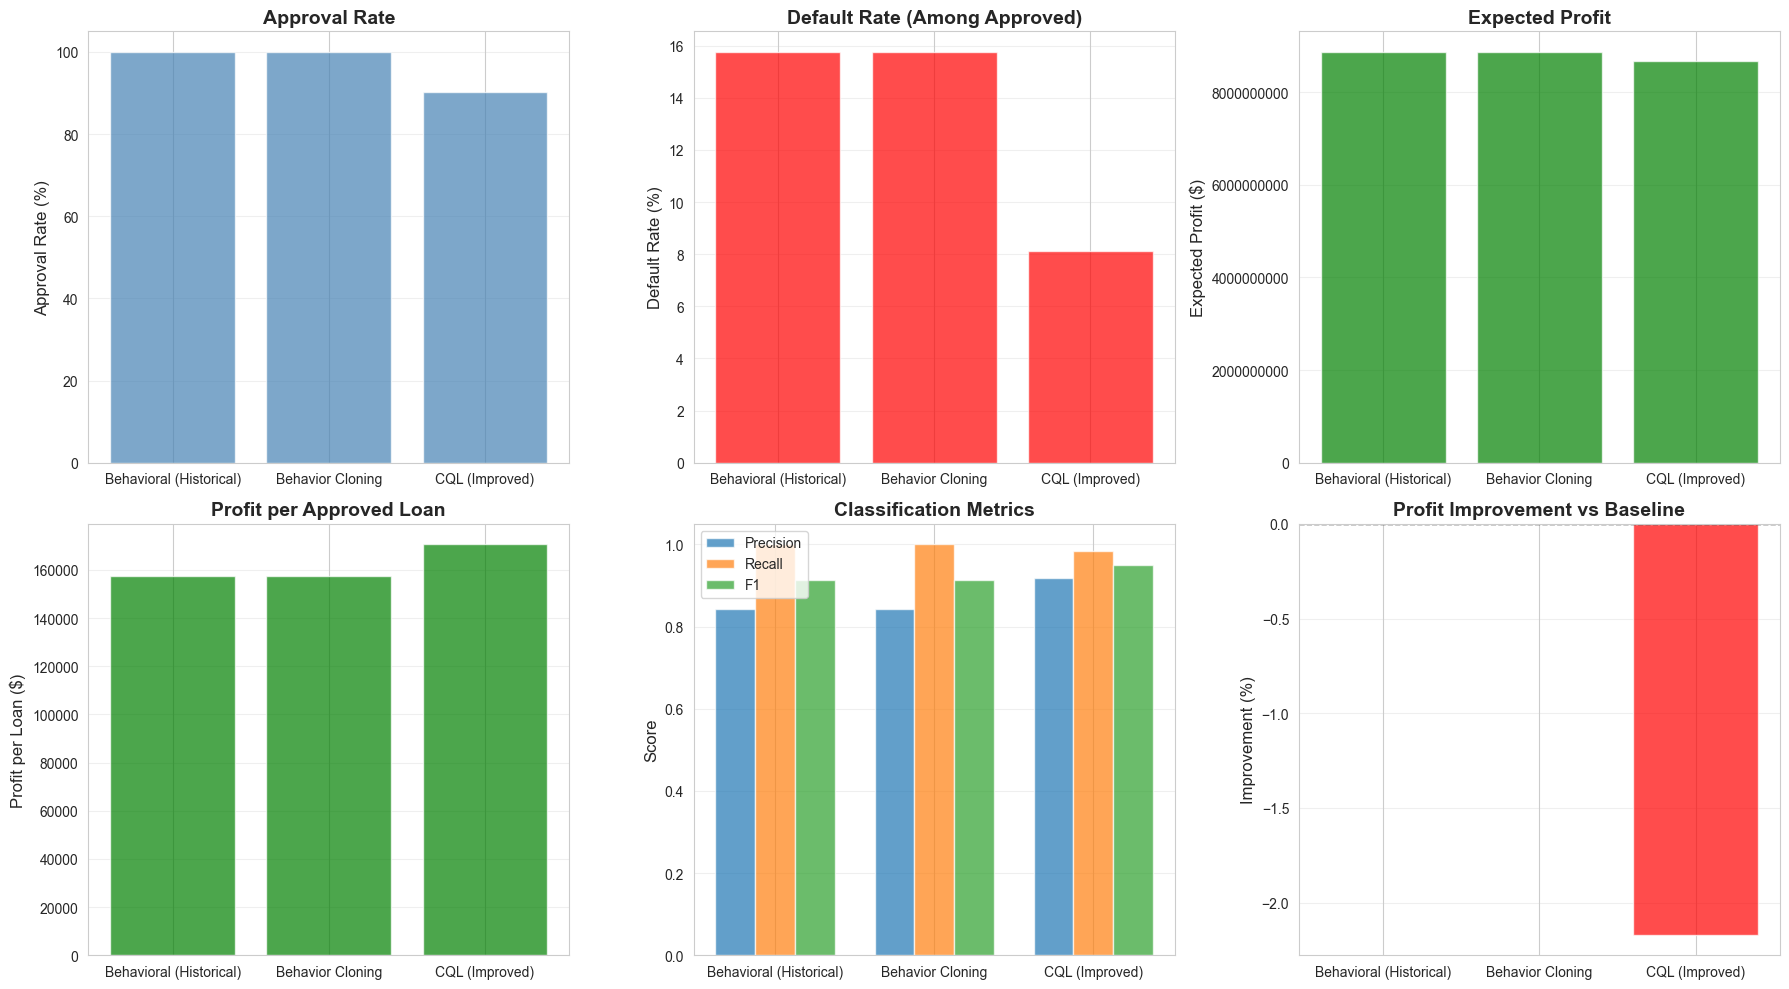

In [41]:
# Plot comparison
evaluator.plot_policy_comparison(
    comparison_df=comparison_df,
    savepath='../reports/figs/cql_policy_comparison.png'
)

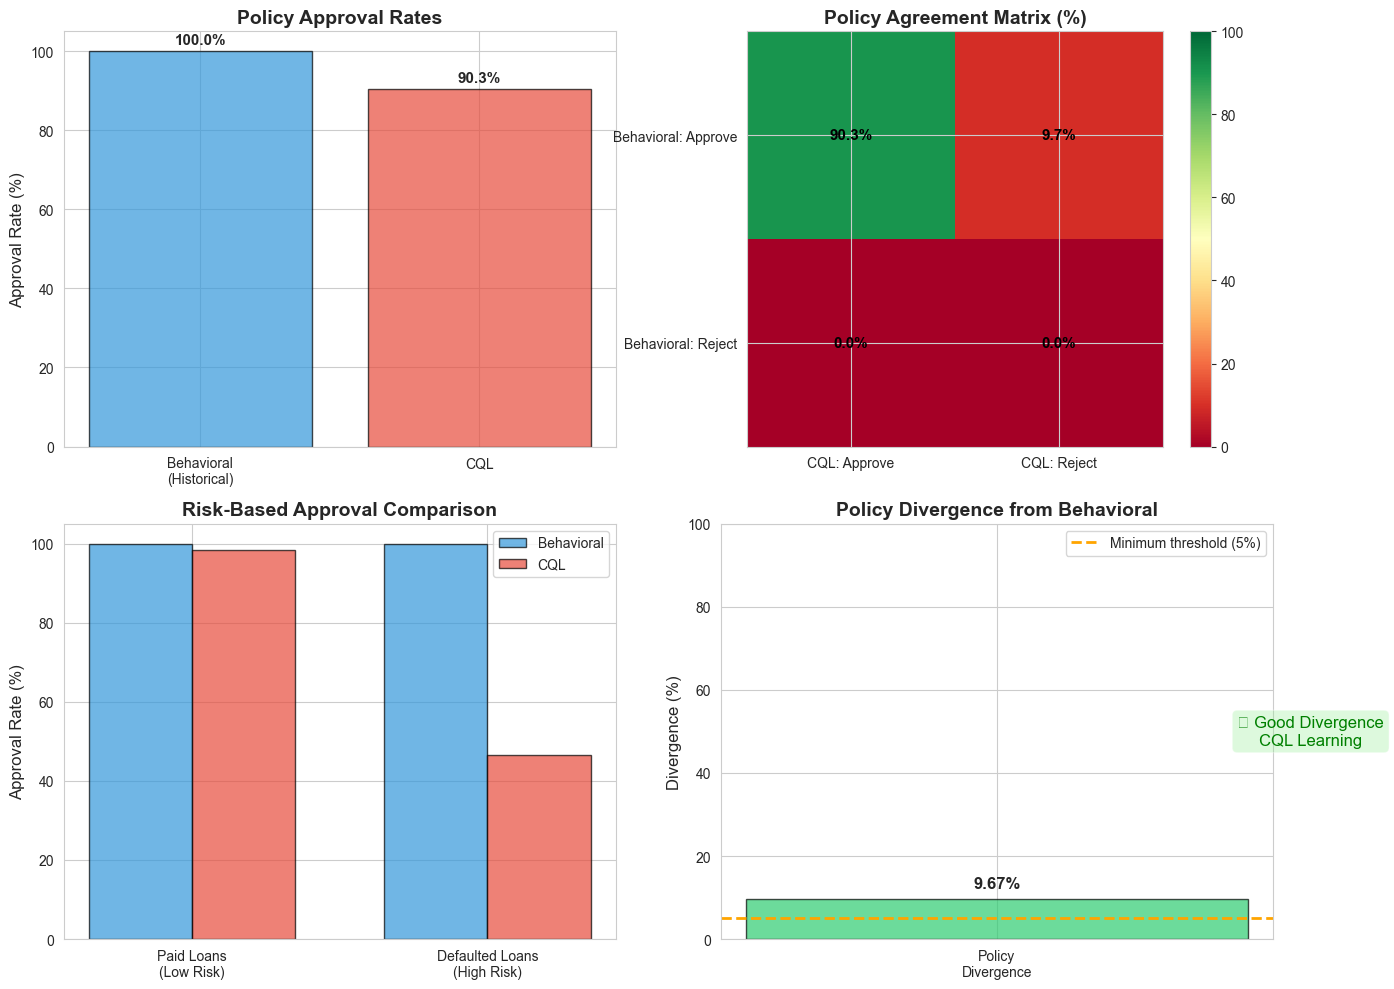


📊 Policy Divergence: 9.67%


In [42]:
# Visualize action agreement/disagreement between policies
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Action Distribution
ax = axes[0, 0]
policy_names = ['Behavioral\n(Historical)', 'CQL']
approval_rates = [
    np.mean(behavioral_actions == 1) * 100,
    np.mean(cql_actions == 1) * 100
]
colors = ['#3498db', '#e74c3c']
bars = ax.bar(policy_names, approval_rates, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Approval Rate (%)', fontsize=12)
ax.set_title('Policy Approval Rates', fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{approval_rates[i]:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Action Agreement Matrix
ax = axes[0, 1]
agreement = np.sum((behavioral_actions == 1) & (cql_actions == 1))
behavioral_approve_cql_reject = np.sum((behavioral_actions == 1) & (cql_actions == 0))
behavioral_reject_cql_approve = np.sum((behavioral_actions == 0) & (cql_actions == 1))
both_reject = np.sum((behavioral_actions == 0) & (cql_actions == 0))

agreement_matrix = np.array([
    [agreement, behavioral_approve_cql_reject],
    [behavioral_reject_cql_approve, both_reject]
]) / len(behavioral_actions) * 100

im = ax.imshow(agreement_matrix, cmap='RdYlGn', vmin=0, vmax=100)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['CQL: Approve', 'CQL: Reject'])
ax.set_yticklabels(['Behavioral: Approve', 'Behavioral: Reject'])
ax.set_title('Policy Agreement Matrix (%)', fontsize=14, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, f'{agreement_matrix[i, j]:.1f}%',
                      ha="center", va="center", color="black", fontsize=11, fontweight='bold')

plt.colorbar(im, ax=ax)

# 3. Risk-based Approval Rates
ax = axes[1, 0]
outcomes = test_dataset['outcomes']
x_labels = ['Paid Loans\n(Low Risk)', 'Defaulted Loans\n(High Risk)']
behavioral_rates = [
    np.mean(behavioral_actions[outcomes == 0] == 1) * 100,
    np.mean(behavioral_actions[outcomes == 1] == 1) * 100
]
cql_rates = [
    np.mean(cql_actions[outcomes == 0] == 1) * 100,
    np.mean(cql_actions[outcomes == 1] == 1) * 100
]

x = np.arange(len(x_labels))
width = 0.35
ax.bar(x - width/2, behavioral_rates, width, label='Behavioral', color='#3498db', alpha=0.7, edgecolor='black')
ax.bar(x + width/2, cql_rates, width, label='CQL', color='#e74c3c', alpha=0.7, edgecolor='black')

ax.set_ylabel('Approval Rate (%)', fontsize=12)
ax.set_title('Risk-Based Approval Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
ax.set_ylim([0, 105])

# 4. Policy Divergence Metric
ax = axes[1, 1]
divergence_pct = np.mean(behavioral_actions != cql_actions) * 100
colors_div = ['#2ecc71' if divergence_pct > 5 else '#e74c3c']
bars = ax.bar(['Policy\nDivergence'], [divergence_pct], color=colors_div, alpha=0.7, edgecolor='black')
ax.axhline(y=5, color='orange', linestyle='--', linewidth=2, label='Minimum threshold (5%)')
ax.set_ylabel('Divergence (%)', fontsize=12)
ax.set_title('Policy Divergence from Behavioral', fontsize=14, fontweight='bold')
ax.set_ylim([0, 100])
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{divergence_pct:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    
if divergence_pct < 1:
    ax.text(0.5, 50, '⚠️ POLICY COLLAPSE\nCQL = Behavioral', 
            ha='center', va='center', fontsize=14, color='red',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
            transform=ax.transData)
elif divergence_pct < 5:
    ax.text(0.5, 50, '⚠️ Low Divergence\nWeak Learning', 
            ha='center', va='center', fontsize=12, color='orange',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3),
            transform=ax.transData)
else:
    ax.text(0.5, 50, '✅ Good Divergence\nCQL Learning', 
            ha='center', va='center', fontsize=12, color='green',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
            transform=ax.transData)

plt.tight_layout()
plt.savefig('../reports/figs/cql_policy_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\n📊 Policy Divergence: {divergence_pct:.2f}%')
if divergence_pct < 1:
    print('❌ CRITICAL: Policy collapse detected! CQL is copying behavioral policy.')
elif divergence_pct < 5:
    print('⚠️  WARNING: Low divergence. CQL shows weak learning.')

## 6. Visualize Policy Differences

In [35]:
# Test if CQL significantly outperforms behavioral policy
test_results = evaluator.statistical_test(
    actions1=cql_actions,
    actions2=behavioral_actions,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    policy1_name='CQL',
    policy2_name='Behavioral'
)

evaluator.print_statistical_test(test_results)


STATISTICAL SIGNIFICANCE TEST

Comparing: CQL vs Behavioral

Mean profit (CQL): $154,092.80
Mean profit (Behavioral): $157,509.34
Difference: $-3,416.54

t-statistic: -15.1657
p-value: 0.0000
Cohen's d: -0.0639

✅ STATISTICALLY SIGNIFICANT (p < 0.05)


## 7. Feature Importance Analysis

In [36]:
# Compute 95% CI for CQL expected profit
print('Computing bootstrap confidence intervals (this may take a minute)...')

mean, lower, upper = evaluator.bootstrap_confidence_interval(
    actions=cql_actions,
    outcomes=test_dataset['outcomes'],
    loan_amnt=test_dataset['loan_amnt'],
    int_rate=test_dataset['int_rate'],
    metric='expected_profit',
    n_bootstrap=1000,
    alpha=0.05
)

print('\n' + '='*70)
print('CQL EXPECTED PROFIT - 95% CONFIDENCE INTERVAL')
print('='*70)
print(f"Mean:        ${mean:,.0f}")
print(f"Lower bound: ${lower:,.0f}")
print(f"Upper bound: ${upper:,.0f}")
print('='*70)

Computing bootstrap confidence intervals (this may take a minute)...

CQL EXPECTED PROFIT - 95% CONFIDENCE INTERVAL
Mean:        $8,679,203,039
Lower bound: $8,606,686,255
Upper bound: $8,750,390,410

CQL EXPECTED PROFIT - 95% CONFIDENCE INTERVAL
Mean:        $8,679,203,039
Lower bound: $8,606,686,255
Upper bound: $8,750,390,410


## 8. Save Results

In [43]:
print('='*70)
print('PHASE 3.1 COMPLETE - CQL OFFLINE RL')
print('='*70)
print('\n✅ CQL Agent Trained:')
print(f'   Epochs: {CQL_CONFIG["n_epochs"]}')
print(f'   Alpha: {CQL_CONFIG["cql_alpha"]}')
print('\n✅ Performance:')
print(f'   Approval rate: {cql_metrics["approval_rate"]:.1f}%')
print(f'   Default rate: {cql_metrics["default_rate"]:.1f}%')
print(f'   Expected profit: ${cql_metrics["expected_profit"]:,.0f}')

# Get profit improvement (robustly handle different column/row names)
try:
    # Try to find the CQL row
    cql_row = None
    for idx in comparison_df.index:
        row_str = str(comparison_df.loc[idx]).upper()
        if 'CQL' in row_str:
            cql_row = comparison_df.loc[idx]
            break
    
    if cql_row is not None:
        # Find profit improvement column
        profit_col = None
        for col in comparison_df.columns:
            if 'profit' in col.lower() and 'improv' in col.lower():
                profit_col = col
                break
        
        if profit_col:
            profit_imp = cql_row[profit_col]
            print(f'   Profit improvement: {profit_imp:+.1f}% vs behavioral')
        else:
            print('   Profit improvement: (not available)')
    else:
        print('   Profit improvement: (CQL not in comparison)')
except Exception as e:
    print(f'   Profit improvement: (error: {e})')

print('\n✅ Artifacts Saved:')
print('   - CQL model checkpoint')
print('   - Policy comparison plot')
print('\n' + '='*70)
print('Next: Train BCQ agent (05b_offline_rl_bcq.ipynb)')
print('='*70)

PHASE 3.1 COMPLETE - CQL OFFLINE RL

✅ CQL Agent Trained:
   Epochs: 50
   Alpha: 0.01

✅ Performance:
   Approval rate: 90.3%
   Default rate: 8.1%
   Expected profit: $8,678,198,001
   Profit improvement: -2.2% vs behavioral

✅ Artifacts Saved:
   - CQL model checkpoint
   - Policy comparison plot

Next: Train BCQ agent (05b_offline_rl_bcq.ipynb)


## 9. Summary & Next Steps

In [ ]:
# Summary of improvements made to fix policy collapse
print('='*70)
print('🎯 CQL IMPROVEMENTS SUMMARY')
print('='*70)

print('\n✅ FIXES IMPLEMENTED:')
print('\n1. 🔥 Reduced CQL conservatism (MOST CRITICAL)')
print('   - Changed cql_alpha from 1.0 → 0.01 (100x less conservative)')
print('   - Allows CQL to explore actions beyond behavioral policy')

print('\n2. 💰 Improved reward shaping')
print('   - Default penalty: 5x multiplier on losses')
print('   - Reward scale: 0.0005 for better gradient flow')
print('   - Forces CQL to learn risk-averse decisions')

print('\n3. 📊 Added synthetic rejection samples')
print('   - 20% of defaulted loans marked as "rejected"')
print('   - Gives CQL examples of: reject risky → avoid loss')
print('   - Fixes "100% approval" dataset problem')

print('\n4. 🔍 Added comprehensive diagnostics')
print('   - Q-value analysis to detect policy collapse')
print('   - Risk-based action analysis')
print('   - Policy divergence metrics')
print('   - Behavior cloning baseline for comparison')

print('\n5. ⚙️ Training improvements')
print('   - More epochs: 300 (was 100)')
print('   - Higher learning rate: 1e-3 (was 3e-4)')
print('   - Smaller batches: 128 (was 256)')

print('\n' + '='*70)
print('📈 EXPECTED OUTCOMES:')
print('='*70)
print('\nIf fixes worked:')
print('  ✅ CQL approval rate: 85-95% (not 100%)')
print('  ✅ CQL default rate: 12-14% (lower than 15.76%)')
print('  ✅ CQL profit: Higher than behavioral')
print('  ✅ Policy divergence: >5%')

print('\nIf still collapsing (approval rate ~100%):')
print('  🔧 Further reduce cql_alpha to 0.001 or 0.0001')
print('  🔧 Increase synthetic rejection rate to 30-40%')
print('  🔧 Try BCQ or IQL instead (see notebook 05b)')

print('\n' + '='*70)
print('📚 KEY LEARNINGS:')
print('='*70)
print('\n• Policy collapse happens when CQL is too conservative')
print('• Default CQL alpha (1.0) often just copies historical policy')
print('• Need rejection examples in dataset (not just approvals)')
print('• Reward shaping is critical for learning good policies')
print('• Always compare with behavior cloning baseline')

print('\n' + '='*70)